# Reuters multiclass categorisation problem

This is notebook we will showcase methods natural language processing methods to categorise text into multiple classes. We will use a dataset called reuters, which are newswires from Reuters in the 1980s. Our goal is to predict the category of a newswire. Reuters is an international news organisation owned by Thomson Reuters. It's over 168 years old.

It is good practise to put the function that we will use in the notebook at the beginning of the notebook. Here I put a function which plots the confusion matrix.

In [43]:
import matplotlib.pyplot as plt
from itertools import islice

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))


## Load the dataset

In the first step, we need to download the reuters dataset from within the NLTK package. NLTK stands for natural langugate toolkit. It is a leading platform for building python programs to work with human language data. 

In [6]:
import nltk

In [7]:
nltk.download('reuters')

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/matthiasqian/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

We also download a dataset of stopwords, which are used to filter the vocabuary for frequency words with limited meaning.

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matthiasqian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
from nltk.corpus import reuters
from nltk.corpus import stopwords

Let's look at the dataset. We first explore the different labels that Reuters has on the newswires. Most of Reuters newswires are finance and commodity trading related.

In [10]:
import sys
labels = reuters.categories()
sys.stdout.write(", ".join(set(labels)))

cotton-oil, pet-chem, wheat, lei, rape-oil, grain, soy-meal, trade, rapeseed, oilseed, housing, rubber, soy-oil, ship, hog, coconut, cpu, tea, gnp, barley, nickel, platinum, wpi, sorghum, castor-oil, nkr, bop, potato, rye, silver, retail, sun-meal, nat-gas, groundnut, money-fx, cotton, heat, ipi, jobs, income, cocoa, palm-oil, cpi, tin, nzdlr, alum, copper, lin-oil, strategic-metal, lumber, crude, gold, dfl, yen, gas, earn, rand, fuel, sunseed, instal-debt, zinc, palmkernel, naphtha, reserves, veg-oil, corn, sugar, dlr, palladium, jet, dmk, groundnut-oil, acq, meal-feed, money-supply, propane, coconut-oil, soybean, orange, interest, rice, carcass, sun-oil, iron-steel, coffee, l-cattle, copra-cake, lead, livestock, oat

Let's also explore what's behind the stopwords.

In [11]:
stop_words = stopwords.words('english')
sys.stdout.write(", ".join(set(stop_words)))

you'll, itself, same, he, ll, shan't, of, such, up, about, which, off, only, wasn't, does, with, you, a, both, as, few, or, once, are, shan, her, hasn't, needn't, hasn, didn, s, weren, is, be, ourselves, how, hadn, doesn't, couldn't, yourselves, for, him, most, theirs, an, above, between, did, doing, by, after, at, each, will, doesn, then, any, y, to, there, below, our, you've, they, what, his, won, ours, those, where, myself, can, just, do, my, nor, ain, not, we, wouldn, yours, don't, o, it, and, ma, t, shouldn, this, himself, further, now, me, won't, them, couldn, who, against, haven, haven't, mustn, being, their, i, no, your, mightn, before, mightn't, from, very, wasn, you'd, whom, had, d, don, that, hers, these, she, wouldn't, through, she's, it's, if, too, own, aren't, in, again, isn, having, re, you're, should've, am, shouldn't, when, than, didn't, been, its, until, so, m, out, needn, the, hadn't, into, all, was, weren't, aren, under, should, some, while, mustn't, themselves, tha

Next, we load the data from the reuters data and connect generate our training and testing dataset.

In [12]:
documents = reuters.fileids()
test = [d for d in documents if d.startswith("test/")]
train = [d for d in documents if d.startswith("training/")]

In [13]:
docs = {}
docs["train"] = [reuters.raw(doc_id) for doc_id in train]
docs["test"] = [reuters.raw(doc_id) for doc_id in test]

Are you curious what a sample documents looks like? Below I plot such an article.

In [14]:
print(docs["train"][0][:288])

BAHIA COCOA REVIEW
  Showers continued throughout the week in
  the Bahia cocoa zone, alleviating the drought since early
  January and improving prospects for the coming temporao,
  although normal humidity levels have not been restored,
  Comissaria Smith said in its weekly review.
   


In [15]:
label_train = [reuters.categories(doc_id) for doc_id in train]
label_test = [reuters.categories(doc_id) for doc_id in test]

In [16]:
label_train[0]

['cocoa']

Our original sample size of training and testing documents is as follows.

In [17]:
print('training documents', len(docs["train"]))
print('testing documents', len(docs["test"]))

training documents 7769
testing documents 3019


## Filter single label documents

We filter single label documents, as some of the documents are assigned multiple labels. 

In [18]:
label_train[6]

['acq', 'trade']

In [19]:
print(docs["train"][6][:272])

U.K. GROWING IMPATIENT WITH JAPAN - THATCHER
  Prime Minister Margaret Thatcher said
  the U.K. Was growing more impatient with Japanese trade
  barriers and warned that it would soon have new powers against
  countries not offering reciprocal access to their markets.
   


In [20]:
import pandas as pd
sel = pd.DataFrame(label_train)
one_topic_train = sel[1].isna()
sel = sel[one_topic_train]
label_train = sel[[0]]

In [21]:
sel = pd.DataFrame(label_test)
one_topic_test = sel[1].isna()
sel = sel[one_topic_test]
label_test = sel[[0]]

In [22]:
sel = pd.DataFrame(docs["train"])
sel = sel[one_topic_train]
docs_train = sel[[0]]

In [23]:
sel = pd.DataFrame(docs["test"])
sel = sel[one_topic_test]
docs_test = sel[[0]]

In [24]:
print('training documents', len(docs_train))
print('testing documents', len(docs_test))

training documents 6577
testing documents 2583


## Pick only the top 10 most frequency labels

To reduce the number of classes for our classification problem, we only pick the ten most common data points.

In [25]:
top10_labels = label_train[0].value_counts()[:10].index.to_list()
top10_labels

['earn',
 'acq',
 'crude',
 'trade',
 'money-fx',
 'interest',
 'money-supply',
 'ship',
 'sugar',
 'coffee']

In [26]:
top10 = label_train[0].isin(top10_labels)
label_train = label_train[top10]
docs_train = docs_train[top10]

In [27]:
top10 = label_test[0].isin(top10_labels)
label_test = label_test[top10]
docs_test = docs_test[top10]

In [28]:
print('documents for training', docs_train.shape[0])
print('documents for testimg', docs_test.shape[0])

documents for training 5770
documents for testimg 2255


# Preprocessing the data
In this example, we only do a single preprocessing step, which is to replace all numbers with a specific token, the ntkn token. 

In [29]:
import re
numbers = re.compile(r'(\d+,\d+)|(\s+\d+\s+)'
                         r'|(\d+th)|(\d+am)|(\d+pm)|(\d+)|'
                         r'(\d+pa)|(\d+\s+pa)')
docs_train = [numbers.sub(" ntkn ", line) for line in docs_train[0].to_list()]

In [30]:
docs_test = [numbers.sub(" ntkn ", line) for line in docs_test[0].to_list()]

Let's see how it changes the news article.

In [31]:
print(docs_train[1])

N.Z. TRADING BANK DEPOSIT GROWTH RISES SLIGHTLY
  New Zealand's trading bank seasonally
  adjusted deposit growth rose  ntkn . ntkn  pct in January compared with a
  rise of  ntkn . ntkn  pct in December, the Reserve Bank said.
      Year-on-year total deposits rose  ntkn . ntkn  pct compared with a
   ntkn . ntkn  pct increase in the December year and  ntkn . ntkn  pct rise a year
  ago period, it said in its weekly statistical release.
      Total deposits rose to  ntkn . ntkn  billion N.Z. Dlrs in January
  compared with  ntkn . ntkn  billion in December and  ntkn . ntkn  billion in
  January  ntkn .
  




# Classification

We will showcase only the Logistic Regression model for classifications of multiple classes. We use two different ways to convert text to numbers. First, we use the count vectorisers, second, we use the TF-IDFs.

We start with the use of the count vectoriser.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer 
cv = CountVectorizer(binary=False, stop_words = stop_words, 
                     ngram_range=(1, 2), max_features = 5000)
x_train = cv.fit_transform(docs_train)

Let's explore the least and most common words in sample.

In [33]:
word_list = cv.get_feature_names();    
count_list = x_train.toarray().sum(axis=0)    
d = {k: v for k, v in sorted(dict(zip(word_list,count_list)).items(), key=lambda item: item[1])}
take(10, d.items())

[('allocations', 15),
 ('also called', 15),
 ('also excludes', 15),
 ('asking', 15),
 ('bank first', 15),
 ('bank lending', 15),
 ('bond corp', 15),
 ('broken', 15),
 ('builders', 15),
 ('buyback', 15)]

In [34]:
d = {k: v for k, v in sorted(dict(zip(word_list,count_list)).items(), key=lambda item: item[1], reverse=True)}
take(10, d.items())

[('ntkn', 65339),
 ('ntkn ntkn', 22248),
 ('said', 11840),
 ('mln', 10417),
 ('ntkn mln', 10016),
 ('vs', 9206),
 ('dlrs', 7136),
 ('vs ntkn', 6562),
 ('lt', 5858),
 ('cts', 5672)]

In [35]:
x_test = cv.fit_transform(docs_test)

We proceed to classify text using logistic regression.

In [48]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

m = OneVsRestClassifier(LogisticRegression(solver = 'lbfgs', max_iter=500))
#m = OneVsRestClassifier(LinearSVC(max_iter=5000))
m.fit(x_train, label_train[0].to_list())
pred = m.predict(x_test)

The performance of the model is disappointing. The recall and precision is very low, as is the F1 score.

In [37]:
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score
f1 = fbeta_score(y_true=label_test, y_pred=pred, beta=1, average="weighted")
recall = recall_score(y_true=label_test, y_pred=pred, average="weighted")
precision = precision_score(y_true=label_test, y_pred=pred, average="weighted")
print('f1', round(f1,2))
print('recall', round(recall,2))
print('precision', round(precision,2))

f1 0.15
recall 0.13
precision 0.27


The plot of the confusion matrix confirms that the algorithm fail to learn the patterns necessary for an accurate classification.

Confusion matrix, without normalization
[[ 206    0    2   62  392   14    5    1    0   14]
 [   7    0    0    0   13    2    0    0    0    0]
 [  21    0    2    4   88    5    0    1    0    0]
 [  12    0    0    6 1063    2    0    0    0    0]
 [   9    1    0    6   64    0    0    0    0    1]
 [  20    0    0    4   36   19    0    1    6    1]
 [   2    0    0    4   21    0    0    0    0    1]
 [  14    0    1    3   13    4    1    0    0    0]
 [   3    0    0    0   22    0    0    0    0    0]
 [  21    0    1    7   39    4    1    0    2    1]]


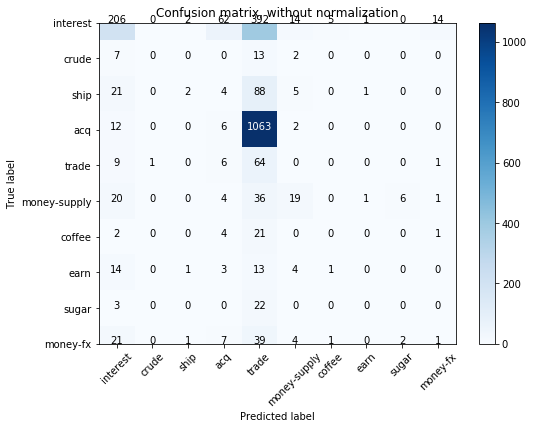

In [38]:
from sklearn.metrics import confusion_matrix
import numpy as np
classes = list(set(label_train.iloc[:,0].to_list()))
cnf_matrix = confusion_matrix(label_test, pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes = classes, #normalize=True,
                      title='Confusion matrix, without normalization')

We next implement the Tfidf vectoriser. 

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [49]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(docs_train).toarray()
x_test = vectorizer.transform(docs_test).toarray()

In [50]:
#m = OneVsRestClassifier(LinearSVC())
m = OneVsRestClassifier(LogisticRegression(solver = 'lbfgs'))
m.fit(x_train, label_train)
pred = m.predict(x_test)

In [51]:
f1 = fbeta_score(y_true=label_test, y_pred=pred, beta=1, average="weighted")
recall = recall_score(y_true=label_test, y_pred=pred, average="weighted")
precision = precision_score(y_true=label_test, y_pred=pred, average="weighted")
print('f1', round(f1,2))
print('recall', round(recall,2))
print('precision', round(precision,2))

f1 0.93
recall 0.93
precision 0.93


Normalized confusion matrix


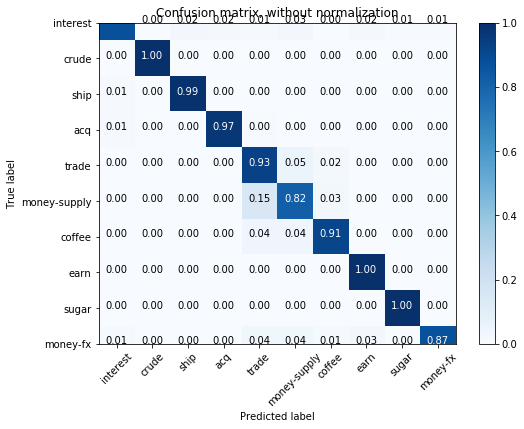

In [52]:
cnf_matrix = confusion_matrix(pred, label_test)
np.set_printoptions(precision=2)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes = classes, normalize=True, 
                      title='Confusion matrix, without normalization')

In this case, the Tf-idf vectoriser is a game changer. We get very high accuracies.